In [1]:
import config
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
with open(os.path.join(config.results_dir, 'context_offline', f'contextResults.pkl'), 'rb') as f:
    results = pickle.load(f)
with open(os.path.join(config.results_dir, 'context_offline', f'predictions_2022-05-31.pkl'), 'rb') as f:
    tcn_predictions, rnn_predictions, rr_predictions, test_velocities = pickle.load(f)

/tmp/ipykernel_180088/2990202089.py:31: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(res, x='test_context', y='mse', hue='train_context',
/tmp/ipykernel_180088/2990202089.py:35: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.stripplot(res, x='test_context', y='mse', hue='train_context',
/tmp/ipykernel_180088/2990202089.py:31: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(res, x='test_context', y='mse', hue='train_context',
/tmp/ipykernel_180088/2990202089.py:35: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.stripplot(res, x='test_context', y='mse', hue='train_context',
/tmp/ipykernel_1

[Text(0.0, 1.0, 'grouped'), Text(0.5, 0, ''), Text(0, 0.5, 'MSE')]

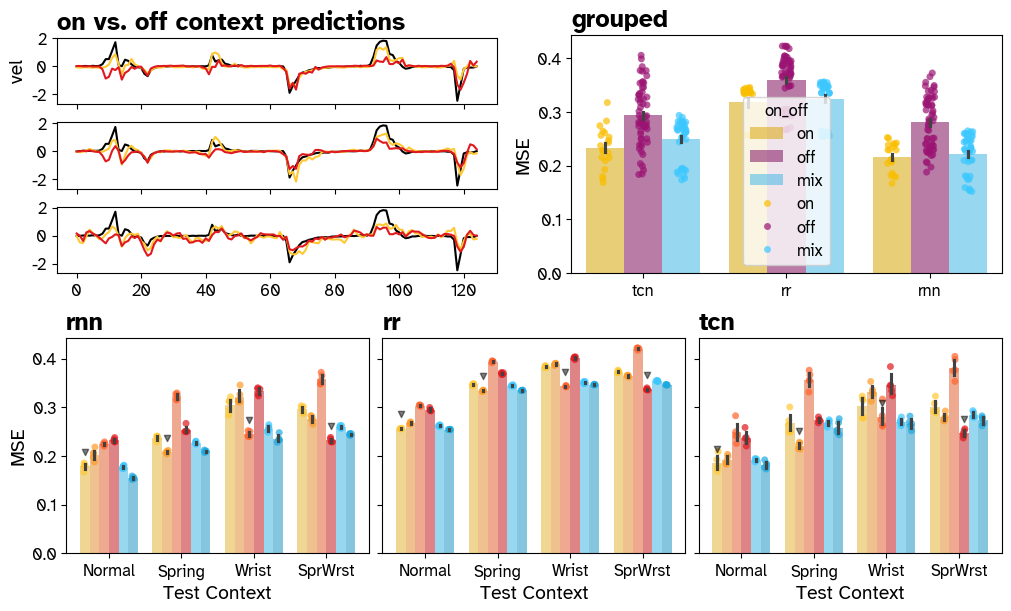

In [87]:
context_fig = plt.figure(figsize=(10,6), layout='constrained')
sfs = context_fig.subfigures(2,1)

bar_axs = sfs[1].subplots(1,3, sharey=True)

top_row = sfs[0].subfigures(1,2)
examples = top_row[0].subplots(3,1, sharex=True)
group_mses = top_row[1].add_subplot()

## example traces of an on and off context prediction maybe?
predictions = (tcn_predictions, rnn_predictions, rr_predictions)
decoders = ('tcn', 'rnn', 'rr')
timeslice = slice(425,550)
truth = test_velocities['Normal'][timeslice,1]
for i in range(3):
    on_example = predictions[i]['Normal']['Normal'][0][timeslice,1]
    off_example = predictions[i]['Normal']['SprWrst'][0][timeslice,1]

    examples[i].plot(truth, 'k')
    examples[i].plot(on_example, color=config.context_palette[0,:])
    examples[i].plot(off_example, color=config.context_palette[3,:])
    examples[i].set(yticks=[-2,0,2])

examples[0].set(title='on vs. off context predictions', ylabel='vel')

date = '2022-05-31'
results_date = results[results['date'] == date]
for i, (decoder, res) in enumerate(results_date.groupby('decoder')):
    # barplot
    width = .8
    sns.barplot(res, x='test_context', y='mse', hue='train_context', 
                hue_order=config.context_order, palette=config.context_palette,
                width=width, ax=bar_axs[i], alpha=0.6)
        
    sns.stripplot(res, x='test_context', y='mse', hue='train_context', 
                hue_order=config.context_order, palette=config.context_palette,
                dodge=True, ax=bar_axs[i], alpha=0.7, zorder=1)
        
    # add arrows above on context
    xtick_loc = {v.get_text(): v.get_position()[0] for v in bar_axs[i].get_xticklabels()}
    onx = np.zeros((len(xtick_loc.keys())))
    ony = np.zeros_like(onx)
    for j, tickkey in enumerate(xtick_loc.keys()):
        context = tickkey
        mask = (res['train_context'] == context) & (res['test_context'] == context)
        barwidth = width/len(config.context_order)
        onx[j] = xtick_loc[tickkey] - (width/2) + barwidth/2 + barwidth * j
        ony[j] = res.loc[mask, 'mse'].mean() + 0.03
    bar_axs[i].scatter(onx, ony, marker='v', c='k', s=20, alpha=0.5)
    bar_axs[i].set_title(decoder)
    
    if i != 0:
        bar_axs[i].set(ylabel=None)
    bar_axs[i].get_legend().remove()
    bar_axs[i].set(title=decoder, xlabel='Test Context', ylabel='MSE')


sns.barplot(results_date, x='decoder', y='mse', hue='on_off', hue_order=['on','off','mix'],
            ax=group_mses, palette=config.context_group_palette, alpha=.6, errorbar='se')
sns.stripplot(results_date, x='decoder', y='mse', hue='on_off', hue_order=['on','off','mix'],
            ax=group_mses, palette=config.context_group_palette, dodge=True, alpha=0.7, zorder=1)

group_mses.set(title='grouped', xlabel=None, ylabel='MSE')

In [44]:
mean_mixed = results.groupby(['decoder','train_context'])['mse'].mean()

In [20]:
mean_mixed

decoder  train_context
rnn      Mixed            0.342872
         Mixed_Full       0.300290
         Normal           0.373698
         SprWrst          0.376991
         Spring           0.369585
         Wrist            0.384173
rr       Mixed            0.467279
         Mixed_Full       0.456486
         Normal           0.493812
         SprWrst          0.492294
         Spring           0.481613
         Wrist            0.498282
tcn      Mixed            0.369024
         Mixed_Full       0.338967
         Normal           0.393354
         SprWrst          0.393026
         Spring           0.384653
         Wrist            0.406582
Name: mse, dtype: float64

In [22]:
tcn_mses = results.loc[results['decoder'] == 'tcn',:].reset_index()

In [26]:
tcn_mses.loc[results['train_context'] == 'Mixed_Full',:]['mse'].mean()
tcn_mses.loc[tcn_mses['train_context'] == 'Mixed_Full',:]['mse'].mean()

0.3389667484273855